In [1]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.10731129348278046,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.0877455323934555,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.05338406190276146,
  'token': 2047,
  'token_str': 'new',
  'sequence': "hello i'm a new model."},
 {'score': 0.04667217284440994,
  'token': 3565,
  'token_str': 'super',
  'sequence': "hello i'm a super model."},
 {'score': 0.027096018195152283,
  'token': 2986,
  'token_str': 'fine',
  'sequence': "hello i'm a fine model."}]

In [2]:
#For POS!!!!

import stanza
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos')

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-04-02 05:42:26 INFO: Downloaded file to /Users/apthebest1931/stanza_resources/resources.json
2024-04-02 05:42:26 INFO: Downloading default packages for language: en (English) ...
2024-04-02 05:42:27 INFO: File exists: /Users/apthebest1931/stanza_resources/en/default.zip
2024-04-02 05:42:28 INFO: Finished downloading models and saved to /Users/apthebest1931/stanza_resources
2024-04-02 05:42:28 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-02 05:42:29 INFO: Downloaded file to /Users/apthebest1931/stanza_resources/resources.json
2024-04-02 05:42:29 WARNING: Language en package default expects mwt, which has been added
2024-04-02 05:42:29 INFO: Loading thes

In [12]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

# Load the model and tokenizer
model_name = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)


data = []
import json
file_path = 'streusle-4.4/streusle.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
original_token = []
masked_applied_sentences = []
masked_sentences = []
for sentence in data:
    original_sentence = sentence["text"]
    tokens = original_sentence.split()
    masked_versions = []
    for i in range(len(tokens)):
        masked_sentence = " ".join(tokens[:i] + ['[MASK]'] + tokens[i+1:])
        original_token = "".join(tokens[i])
        predicted_tokens = {}
        prediction_output = []
        inputs = tokenizer(masked_sentence, return_tensors="pt")
        masked_applied_sentences.append(masked_sentence)
        # Get hidden states and other outputs from the model
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states  # hidden states from each layer

        # Apply the MLM head to each layer's output to get predictions
        predictions_per_layer = []
        
        for layer_hidden_states in hidden_states:
            # Apply the MLM prediction head to get logits
            logits = model.cls(layer_hidden_states)
            predictions = torch.softmax(logits, dim=-1)
            predictions_per_layer.append(predictions)

        predicted_tokens['id'] = {}
        masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
        actual_sentence = " ".join(tokens[:i] + [f'{original_token}'] + tokens[i+1:])
        for j in range(len(predictions_per_layer)):
            predicted_tokens['id'][f'layer{j}'] = {}
            predicted_token_id = predictions_per_layer[j][0, masked_index].argmax().item()  # For the first layer
            doc = nlp(tokenizer.decode([predicted_token_id]))  # Process the token_str to get POS
            predicted_pos_tag = doc.sentences[0].words[0].upos
            doc1 = nlp(original_token)
            actual_pos_tag = doc1.sentences[0].words[0].upos
            predicted_tokens['id'][f'layer{j}']['predicted_token'] = tokenizer.decode([predicted_token_id])
            predicted_tokens['id'][f'layer{j}']['actual_token'] = original_token
            predicted_tokens['id'][f'layer{j}']['predicted_pos'] = predicted_pos_tag
            predicted_tokens['id'][f'layer{j}']['actual_pos'] = actual_pos_tag
            predicted_tokens['id'][f'layer{j}']['predicted_sentence'] = " ".join(tokens[:i] + [f'{tokenizer.decode([predicted_token_id])}'] + tokens[i+1:])
        masked_sentences.append((actual_sentence, masked_sentence, predicted_tokens))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
import numpy as np

def calculate_accuracy(masked_sentences):
    correct_predictions_word = 0
    total_predictions = 0
    correct_predictions_pos = 0
    accuracy_word = [0]*13
    accuracy_pos = [0]*13
    accuracy_only_pos = [0]*13
    for i in range(len(masked_sentences)):
        actual_sentence = masked_sentences[i][0]
        masked_sentence = masked_sentences[i][1]
        predicted_tokens = masked_sentences[i][2]['id']
        for j in range(13):
            if predicted_tokens[f'layer{j}']['actual_token'].lower() == predicted_tokens[f'layer{j}']['predicted_token'].lower():
                accuracy_word[j] += 1
            if predicted_tokens[f'layer{j}']['actual_token'].lower() == predicted_tokens[f'layer{j}']['predicted_token'].lower() and predicted_tokens[f'layer{j}']['actual_pos'].lower() == predicted_tokens[f'layer{j}']['predicted_pos'].lower():
                accuracy_pos[j] += 1
            if predicted_tokens[f'layer{j}']['actual_pos'].lower() == predicted_tokens[f'layer{j}']['predicted_pos'].lower():
                accuracy_only_pos[j] += 1
        total_predictions +=1
    accuracy_word = list((np.array(accuracy_word))/total_predictions)
    accuracy_pos = list((np.array(accuracy_pos))/total_predictions)
    accuracy_only_pos = list((np.array(accuracy_only_pos))/total_predictions)
    return accuracy_word, accuracy_pos, accuracy_only_pos


accuracy_word, accuracy_pos, accuracy_only_pos = calculate_accuracy(masked_sentences)
print(f"Accuracy word: {accuracy_word}")
print(f"Accuracy_only_pos: {accuracy_only_pos}")
print(f"Accuracy pos: {accuracy_pos}")
        

Accuracy word: [0.007407559826333875, 0.029465626864750304, 0.09343813658717258, 0.11992016296631618, 0.15082614868618696, 0.18134117985966788, 0.2175970698985576, 0.24722730920389308, 0.2860141155167802, 0.3304594744747834, 0.3623119817280191, 0.4040412354163666, 0.43266322352311776]
Accuracy_only_pos: [0.048766435523364675, 0.16407745015329533, 0.3403362209098953, 0.37496656309800613, 0.44083211588715815, 0.48433095331179654, 0.5176238194201527, 0.552583386489434, 0.5922961377806127, 0.6170085804234655, 0.6441696331200231, 0.6712689561513612, 0.6707956953846786]
Accuracy pos: [0.007386983271260725, 0.029321590979238255, 0.09300602893063643, 0.11932344286919484, 0.14987962715282208, 0.18006543344513262, 0.21570402683182782, 0.24500504125599293, 0.28344204613263646, 0.3274758739891767, 0.35918434535690036, 0.4006049507191506, 0.42902117327517025]


In [14]:
delta_word = np.diff(accuracy_word, prepend=[0])
delta_pos = np.diff(accuracy_pos, prepend=[0])
delta_only_pos = np.diff(accuracy_only_pos, prepend=[0])
expected_layer_word = np.sum(layers * delta_word) / np.sum(delta_word)
expected_layer_pos = np.sum(layers * delta_pos) / np.sum(delta_pos)
expected_layer_only_pos = np.sum(layers * delta_only_pos) / np.sum(delta_only_pos)


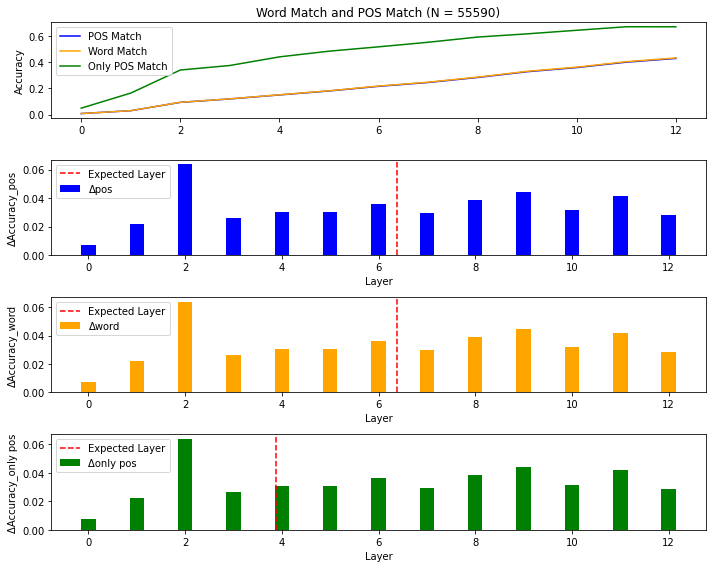

In [32]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
layers = [0,1,2,3,4,5,6,7,8,9,10,11,12]
layers = np.array(layers)
# Top subplot
ax1.plot(layers, accuracy_pos, label='POS Match', color='blue')
ax1.plot(layers, accuracy_word, label='Word Match', color='orange')
ax1.plot(layers, accuracy_only_pos, label='Only POS Match', color='green')
ax1.set_ylabel('Accuracy')
ax1.set_title('Word Match and POS Match (N = 55590)')
ax1.legend()

# Bottom subplot for Δpos and Δword
ax2.bar(layers, delta_pos, width=0.3, label='Δpos', color='blue')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axvline(x=expected_layer_pos, color='red', linestyle='--', label='Expected Layer')  # Example layer
ax2.set_xlabel('Layer')
ax2.set_ylabel('ΔAccuracy_pos')
ax2.legend()


ax3.bar(layers, delta_word, width=0.3, label='Δword', color='orange')
ax3.axhline(y=0, color='black', linewidth=0.5)
ax3.axvline(x=expected_layer_word, color='red', linestyle='--', label='Expected Layer')  # Example layer
ax3.set_xlabel('Layer')
ax3.set_ylabel('ΔAccuracy_word')
ax3.legend()

ax4.bar(layers, delta_word, width=0.3, label='Δonly pos', color='green')
ax4.axhline(y=0, color='black', linewidth=0.5)
ax4.axvline(x=expected_layer_only_pos, color='red', linestyle='--', label='Expected Layer')  # Example layer
ax4.set_xlabel('Layer')
ax4.set_ylabel('ΔAccuracy_only pos')
ax4.legend()
# Tight layout to prevent overlap
plt.tight_layout()



# Show the plot
plt.show()

In [19]:
accuracy_word, accuracy_pos

([0.007407559826333875,
  0.029465626864750304,
  0.09343813658717258,
  0.11992016296631618,
  0.15082614868618696,
  0.18134117985966788,
  0.2175970698985576,
  0.24722730920389308,
  0.2860141155167802,
  0.3304594744747834,
  0.3623119817280191,
  0.4040412354163666,
  0.43266322352311776],
 [0.007386983271260725,
  0.029321590979238255,
  0.09300602893063643,
  0.11932344286919484,
  0.14987962715282208,
  0.18006543344513262,
  0.21570402683182782,
  0.24500504125599293,
  0.28344204613263646,
  0.3274758739891767,
  0.35918434535690036,
  0.4006049507191506,
  0.42902117327517025])